In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from dataset import CustomImageDataset, CustomSampler
from torch.utils.data import random_split
import os
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder

In [20]:
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

transform = transforms.Compose([
    transforms.Resize((64, 64)), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
batch_size = 32
# 加載數據集
train_dataset = ImageFolder(root='/root/notebooks/nfs/work/barry.chen/DenoisingDiffusionProbabilityModel-ddpm-/dataset/classifier_defect_type/', transform=transform)
test_dataset = ImageFolder(root='/root/notebooks/nfs/work/barry.chen/Phison/Conditional_Diffusion/CDDIM/SampledImg/phison_group/35/broke_group3', transform=transform)
# # 創建 DataLoader
# 分割數據集
train_size = int(0.8 * len(train_dataset))  # 假設80%用於訓練
val_size = len(train_dataset) - train_size
traindataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# 創建 DataLoader
trainloader = torch.utils.data.DataLoader(traindataset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
# 檢查數據集的類別
classes = train_dataset.classes
print("Classes:", classes)


# 顯示數據集的大小
print("train Dataset size:", len(train_dataset))
print("test Dataset size:", len(test_dataset))

Using device: cuda:0
Classes: ['broke', 'unbroke']
train Dataset size: 5400
test Dataset size: 10511


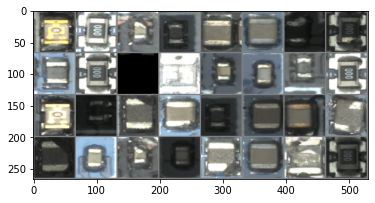

unbroke unbroke broke unbroke unbroke unbroke broke broke unbroke unbroke unbroke unbroke unbroke unbroke unbroke unbroke unbroke unbroke broke broke unbroke unbroke unbroke broke broke unbroke broke unbroke broke unbroke unbroke unbroke


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
batch_size = batch_size

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

torch.Size([32, 3, 64, 64])


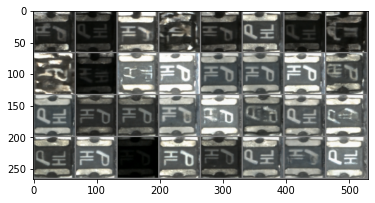

In [4]:
dataiter = iter(testloader)
images, labels = next(dataiter)
print(images.size())
# print images
imshow(torchvision.utils.make_grid(images))
#print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [5]:
from torchvision.models import resnet18
model = resnet18()
model.fc = nn.Sequential(
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, 1),
    )
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.BCEWithLogitsLoss(reduction="mean").to(device)

In [30]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
#         self.bn1 = nn.BatchNorm2d(16)
#         self.relu1 = nn.ReLU(inplace=True)
#         self.pool1 = nn.MaxPool2d(kernel_size=2)
#         self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
#         self.bn2 = nn.BatchNorm2d(32)
#         self.relu2 = nn.ReLU(inplace=True)
#         self.pool2 = nn.MaxPool2d(kernel_size=2)
#         self.fc1 = nn.Linear(32 * 8 * 8, 64)
#         self.relu3 = nn.ReLU(inplace=True)
#         self.fc2 = nn.Linear(64, 1)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu1(x)
#         x = self.pool1(x)
#         x = self.conv2(x)
#         x = self.bn2(x)
#         x = self.relu2(x)
#         x = self.pool2(x)
#         x = x.view(-1, 32 * 8 * 8)
#         x = self.fc1(x)
#         x = self.relu3(x)
#         x = self.fc2(x)
#         x = self.sigmoid(x)
#         return x

In [31]:
# model=Net()
# model.to(device)
# criterion = nn.BCELoss().to(device)
# optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum= 0.9)

In [6]:
n_epochs = 50 # you may increase this number to train a final model

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in trainloader:
        # move tensors to GPU if CUDA is available

        data, target = data.cuda(), target.unsqueeze(1).float().cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valloader:
        # move tensors to GPU if CUDA is available
        data, target = data.cuda(), target.unsqueeze(1).float().cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(trainloader.dataset)
    valid_loss = valid_loss/len(valloader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'classifier_defect_tpye_w.pth')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.439275 	Validation Loss: 0.303138
Validation loss decreased (inf --> 0.303138).  Saving model ...
Epoch: 2 	Training Loss: 0.233320 	Validation Loss: 0.336564
Epoch: 3 	Training Loss: 0.185052 	Validation Loss: 0.204801
Validation loss decreased (0.303138 --> 0.204801).  Saving model ...
Epoch: 4 	Training Loss: 0.138487 	Validation Loss: 0.153925
Validation loss decreased (0.204801 --> 0.153925).  Saving model ...
Epoch: 5 	Training Loss: 0.082112 	Validation Loss: 0.168853
Epoch: 6 	Training Loss: 0.088409 	Validation Loss: 0.283658
Epoch: 7 	Training Loss: 0.053209 	Validation Loss: 0.127391
Validation loss decreased (0.153925 --> 0.127391).  Saving model ...
Epoch: 8 	Training Loss: 0.047050 	Validation Loss: 0.103174
Validation loss decreased (0.127391 --> 0.103174).  Saving model ...
Epoch: 9 	Training Loss: 0.040212 	Validation Loss: 0.094648
Validation loss decreased (0.103174 --> 0.094648).  Saving model ...
Epoch: 10 	Training Loss: 0.037346 	Valida

In [21]:
ckpt = torch.load('classifier_defect_tpye_w.pth')
model.load_state_dict(ckpt)

<All keys matched successfully>

In [24]:
correct = 0
total = 0
i=0
e = 90_33
model.eval()
with torch.no_grad():
    for data, target in testloader:
        data, target = data.cuda(), target.unsqueeze(1).float().cuda()
        outputs = model(data)
#         print(F.sigmoid(outputs))
        predicted = F.sigmoid(outputs) < 0.99984
    
#         print(predicted)
        for img in data[predicted.view(-1)]:
            img = img * 0.5 + 0.5
            save_image(img, f"/root/notebooks/nfs/work/barry.chen/Phison/Conditional_Diffusion/CDDIM/select/epoch{e}_{i}.jpg")
            i += 1
        correct += torch.sum(predicted).item()
        total += target.size(0)
#print(correct/total)
print(i)

151


In [ ]:

# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
classes = ['broke', 'unbroke']
model.eval()
i=1
# iterate over test data
len(testloader)

for data, target in testloader:
    i=i+1
    if len(target)!=batch_size:
        continue
        
    # move tensors to GPU if CUDA is available

    data, target = data.cuda(), target.unsqueeze(1).float().cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct_tensor = correct_tensor.cpu() 
    correct = np.squeeze(correct_tensor.numpy())
    # calculate test accuracy for each object class
#     print(target)
    
    for i in range(batch_size):       
        label = int(target.data[i])
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    print(classes[i], i)
    print(class_total[i])
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

In [28]:
!pwd

/root/notebooks/nfs/work/barry.chen/Phison/Conditional_Diffusion/CDDIM
